# Planeación agregada optimizada para minimizar costos

### Caso basico:

La empresa Químicos del Norte, se dedica a la producción de botellas de desinfectante para el hogar. La empresa ha estimado su demanda para los siguientes 6 periodos de acuerdo con información histórica que reposa en la base de datos de la compañía. La empresa tiene restricciones en cuanto al almacenamiento del producto en sus bodegas, dado que cuenta con un espacio limitado. La capacidad máxima de almacenamiento es de 28.500 botellas. Se entiende que los costos de almacenamiento tienen un componente fijo dentro de la operación.

Por efectos comerciales, el sistema permite faltantes dado que no es un mercado tan competido, pero se estima que puede ser máximo de 20.000 botellas como valor acumulado en el periodo de planeación. El efecto es un descuento comercial equivalente al 12% del margen de contribución unitario para la empresa.

En cuanto al proceso, el sistema cuenta con 20 llenadoras, las cuales pueden atender 200 botellas diarias cada una. Dado que la capacidad es regularmente mayor a la demanda, no siempre todas las máquinas seencuentran en operación, lo que supone un reto para el departamento de mantenimiento debido a que siuna máquina se encuentra inactiva se le realiza un mantenimiento de control que cuesta 225.000 por cada uno de los periodos de inactividad.

Se tienen 20 operarios disponibles en el sistema, donde cada uno está asignado a una llenadora. Sin embargo, se tiene la restricción que 9 de ellos pertenecen al sindicato y no pueden ser asignados a realizarotras operaciones diferentes. El salario nominal de todos los empleados es de 1.650.000 por periodo máslos recargos que por ley existen.

Cuando el par operario/llenadora no es requerido (operarios no sindicalizados), es asignado a apoyar otras actividades logísticas, y su salario es asumido por otro centro de costos. En el caso de la llenadora, sale de operación y cuando se requiera nuevamente se realiza un alistamiento que cuesta 350.000. Los costos variables de operación de la llenadora son de 185.000 por día de operación. El margen de contribuciónpor cada botella se estima en $2150.

Se encontró una solución factible!
Periodo 0: Costo = $-71,881,000.00
Periodo 1: Costo = $-48,505,000.00
Periodo 2: Costo = $-69,564,400.00
Periodo 3: Costo = $-59,652,000.00
Periodo 4: Costo = $-64,062,000.00
Periodo 5: Costo = $-72,176,000.00

 Costo total: $-385,840,400.00



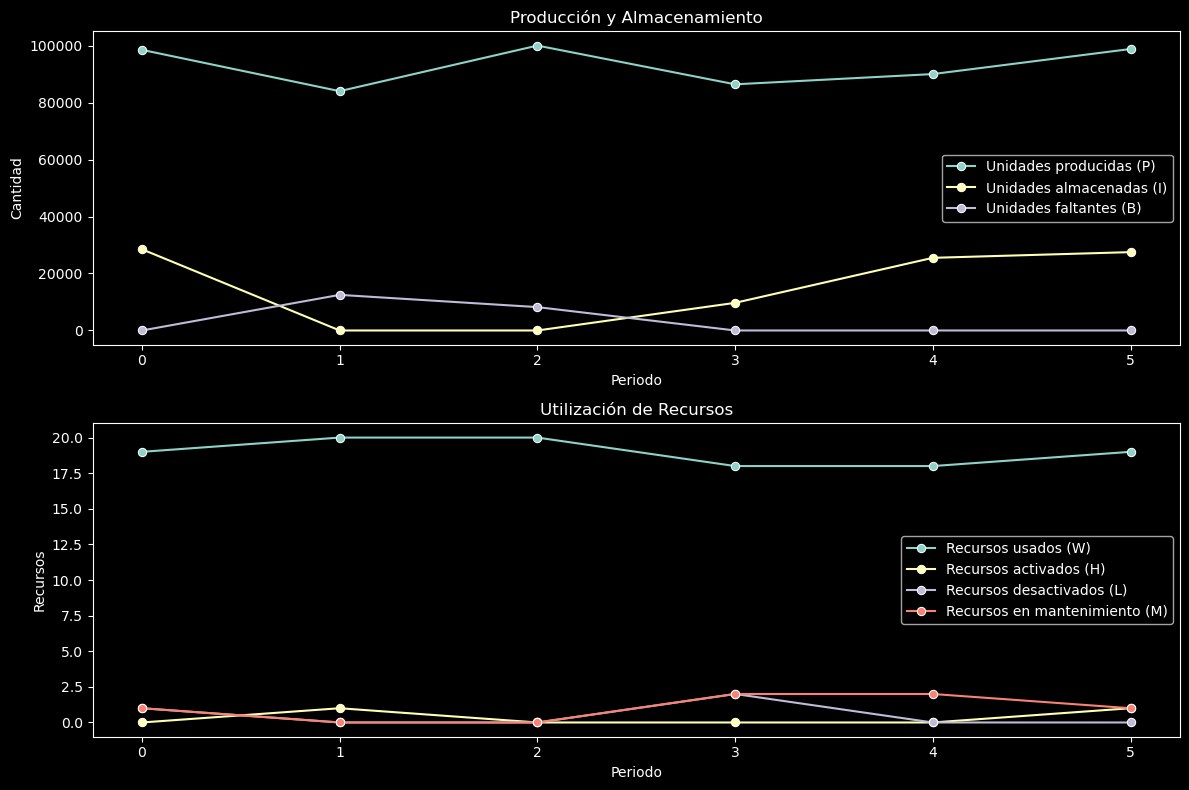

,Periodo,Unidades producidas (P),Unidades almacenadas (I),Unidades faltantes (B),Recursos usados (W),Recursos activados (H),Recursos desactivados (L),Recursos en mantenimiento (M)
0,0,98500.0,28500.0,0.0,19.0,0.0,1.0,1.0
1,1,84000.0,0.0,12500.0,20.0,1.0,0.0,0.0
2,2,100000.0,0.0,8200.0,20.0,0.0,0.0,0.0
3,3,86400.0,9700.0,0.0,18.0,0.0,2.0,2.0
4,4,90000.0,25500.0,0.0,18.0,0.0,0.0,2.0
5,5,98800.0,27500.0,0.0,19.0,1.0,0.0,1.0


In [37]:
import pulp as p
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def planeación_producción(tiempo, días_habiles, demandas, n, Cp, Ci, Cb, Cw, Ch, Cl,Cm):
    
    #Definir modelo
    costo=p.LpProblem("planeación_producción", p.LpMinimize)
    
    #Crear variables de decisión
    P=p.LpVariable.dicts("P",range(tiempo),lowBound=0, cat="Integer") #Número de unidades producidas en cada periodo de tiempo
    I=p.LpVariable.dicts("I",range(tiempo),lowBound=0, cat="Integer") #Número de unidades almacenadas en cada periodo de tiempo
    B=p.LpVariable.dicts("B",range(tiempo),lowBound=0, cat="Integer") #Número de unidades faltantes en cada periodo de tiempo
    W=p.LpVariable.dicts("W",range(tiempo),lowBound=0, cat="Integer") #Número de recursos en cada periodo de tiempo
    H=p.LpVariable.dicts("H",range(tiempo),lowBound=0, cat="Integer") #Número de recursos activados en cada periodo de tiempo
    L=p.LpVariable.dicts("L",range(tiempo),lowBound=0, cat="Integer") #Número de recursos desactivados en cada periodo de tiempo
    M=p.LpVariable.dicts("M",range(tiempo),lowBound=0, cat="Integer") #Número de recursos en mantenimiento en cada periodo de tiempo
    
    #Definir función objetivo
    costo += p.lpSum(P[t]*Cp+I[t]*Ci+B[t]*Cb+W[t]*Cw[t]+H[t]*Ch+L[t]*Cl+M[t]*Cm for t in range(tiempo))

    #Restricción: Capacidad
    for t in range(tiempo):    
        costo += P[t]-(n*días_habiles[t])*W[t]<=0
        
    #Restricción: Balance de recursos
    for t in range(tiempo): 
        if t == 0:
            Wi=20
            costo +=W[t]-H[t]+L[t]==Wi
        else:
            costo +=W[t]-W[t-1]-H[t]+L[t]==0
            
    #Restricción: Balance de inventario
    for t in range(tiempo): 
        if t == 0:
            Ii=0
            Bi=0
            costo += I[t]-B[t]-P[t]==Ii-Bi-demandas[t]
        else:
            costo += I[t]-B[t]-I[t-1]+B[t-1]-P[t]==-demandas[t]

    #Restricción: limite de backorder
    costo += p.lpSum(B[t] for t in range (tiempo)) <= 21000

    #Restricción: limite superior de inventario
    for t in range (tiempo):
        costo += I[t] <= 28500

    #Restricción: Minima cantidad de operarios por sindicato
    for t in range (tiempo):
        costo += W[t] >= 9

    #Restricción: limite de llenadoras
    for t in range (tiempo):
        costo += W[t]+M[t] == 20
    
    costo.solve()

    #Resultados:
    if costo.status == p.LpStatusOptimal:
        print("Se encontró una solución factible!")
    else:
        print("No se encontró ninguna solución factible")
        
    # Calcular costo total
    costo_total = 0
    for t in range(tiempo):
        costo_periodo = (
            P[t].varValue * Cp +
            I[t].varValue * Ci +
            B[t].varValue * Cb +
            W[t].varValue * Cw[t]+
            H[t].varValue * Ch +
            L[t].varValue * Cl +
            M[t].varValue * Cm
        )
        print(f"Periodo {t}: Costo = ${costo_periodo:,.2f}")
        costo_total = costo_total + costo_periodo


    print(f"\n Costo total: ${costo_total:,.2f}\n")

    # Crear DataFrame para almacenar los resultados
    resultados = []
    for t in range(tiempo):
        resultados.append({
            "Periodo": t,
            "Unidades producidas (P)": P[t].varValue,
            "Unidades almacenadas (I)": I[t].varValue,
            "Unidades faltantes (B)": B[t].varValue,
            "Recursos usados (W)": W[t].varValue,
            "Recursos activados (H)": H[t].varValue,
            "Recursos desactivados (L)": L[t].varValue,
            "Recursos en mantenimiento (M)": M[t].varValue
        })

    df_resultados = pd.DataFrame(resultados)                           
    # Visualización gráfica con seaborn
    plt.style.use('dark_background') 
    plt.figure(figsize=(12, 8))

    # Gráfico de unidades producidas, almacenadas y faltantes
    plt.subplot(2, 1, 1)
    sns.lineplot(data=df_resultados, x='Periodo', y='Unidades producidas (P)', marker='o', label='Unidades producidas (P)')
    sns.lineplot(data=df_resultados, x='Periodo', y='Unidades almacenadas (I)', marker='o', label='Unidades almacenadas (I)')
    sns.lineplot(data=df_resultados, x='Periodo', y='Unidades faltantes (B)', marker='o', label='Unidades faltantes (B)')
    plt.title('Producción y Almacenamiento')
    plt.xlabel('Periodo')
    plt.ylabel('Cantidad')
    plt.legend()

    # Gráfico de recursos usados, activados y desactivados
    plt.subplot(2, 1, 2)
    sns.lineplot(data=df_resultados, x='Periodo', y='Recursos usados (W)', marker='o', label='Recursos usados (W)')
    sns.lineplot(data=df_resultados, x='Periodo', y='Recursos activados (H)', marker='o', label='Recursos activados (H)')
    sns.lineplot(data=df_resultados, x='Periodo', y='Recursos desactivados (L)', marker='o', label='Recursos desactivados (L)')
    sns.lineplot(data=df_resultados, x='Periodo', y='Recursos en mantenimiento (M)', marker='o', label='Recursos en mantenimiento (M)')
    plt.title('Utilización de Recursos')
    plt.xlabel('Periodo')
    plt.ylabel('Recursos')
    
    plt.tight_layout()
    plt.show()
                                 
    return df_resultados
    
#Entradas
tiempo=6
días_habiles=[26,21,25,24,25,26]
demandas=[70000,125000,95700,68500,74200,96800]
n=200
#costo de producción de una unidad en el periodo t    
Cp=-2150
#costo de inventario de una unidad en el periodo t
Ci=0
#costo de backorders de una unidad en el periodo t
Cb=258
#costo asociado al uso de un recurso en el periodo t
Cw=[]
for t in range (tiempo):
    Co=1650000*1.54+(185000*(días_habiles[t]))
    Cw.append(Co)
#costo de activación de un recurso en el periodo t
Ch=350000
#costo de desactivación de un recurso en el periodo t
Cl=0
#costo de mantenimiento de un recurso en el periodo t
Cm=225000
planeación_producción(tiempo, días_habiles, demandas, n, Cp, Ci, Cb, Cw, Ch, Cl,Cm)


### Extensión del modelo

Si la bodega no es propiedad de la empresa y el costo de arriendo mensual es
de $2.000.000 por periodo. Plantee los cambios que considere pertinentes en el modelo inicial,
resuélvalo y comente la solución. 

Se encontró una solución factible!

 Costo total: $-358,000,400.00



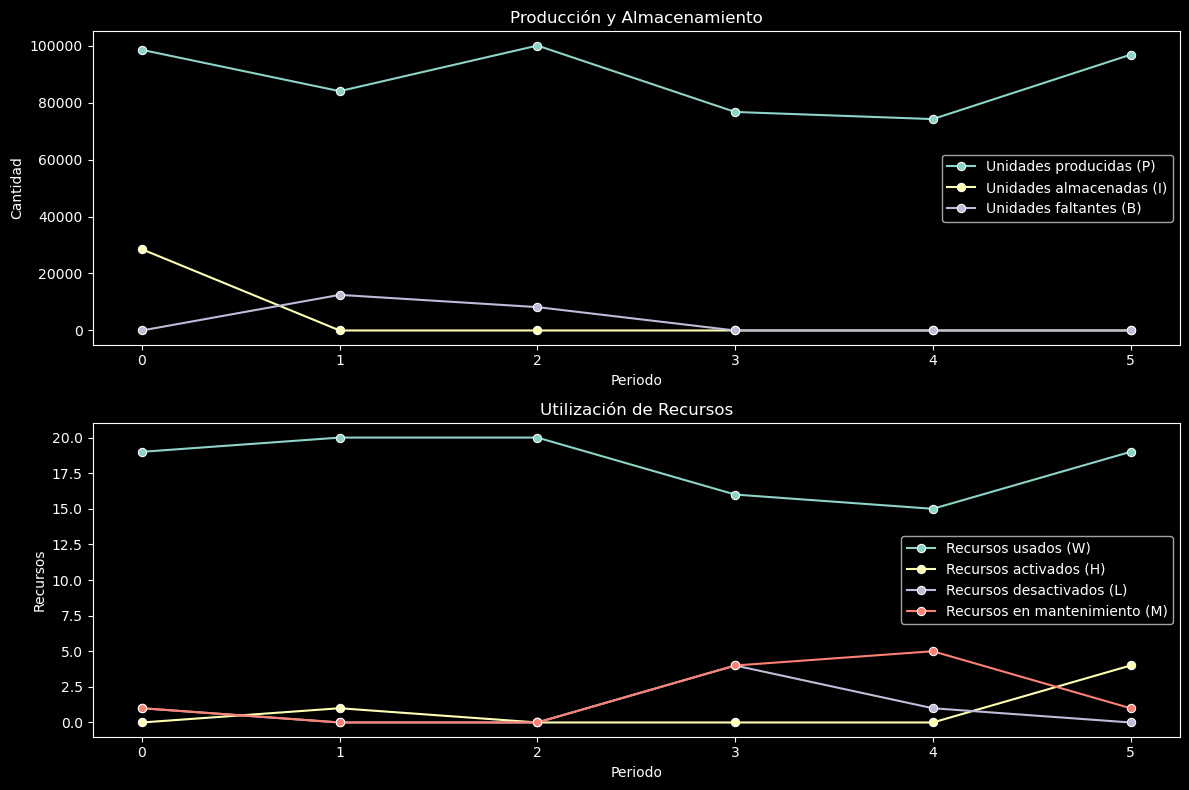

,Periodo,Unidades producidas (P),Unidades almacenadas (I),Unidades faltantes (B),Recursos usados (W),Recursos activados (H),Recursos desactivados (L),Recursos en mantenimiento (M),Uso de arriendo (A)
0,0,98500.0,28500.0,0.0,19.0,0.0,1.0,1.0,1.0
1,1,84000.0,0.0,12500.0,20.0,1.0,0.0,0.0,0.0
2,2,100000.0,0.0,8200.0,20.0,0.0,0.0,0.0,0.0
3,3,76700.0,0.0,0.0,16.0,0.0,4.0,4.0,0.0
4,4,74200.0,0.0,0.0,15.0,0.0,1.0,5.0,0.0
5,5,96800.0,0.0,0.0,19.0,4.0,0.0,1.0,0.0


In [39]:
import pulp as p
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def planeación_producción(tiempo, días_habiles, demandas, n, Cp, Ci, Cb, Cw, Ch, Cl,Cm,Ca):
    
    #Definir modelo
    costo=p.LpProblem("planeación_producción", p.LpMinimize)
    
    #Crear variables de decisión
    P=p.LpVariable.dicts("P",range(tiempo),lowBound=0, cat="Integer") #Número de unidades producidas en cada periodo de tiempo
    I=p.LpVariable.dicts("I",range(tiempo),lowBound=0, cat="Integer") #Número de unidades almacenadas en cada periodo de tiempo
    B=p.LpVariable.dicts("B",range(tiempo),lowBound=0, cat="Integer") #Número de unidades faltantes en cada periodo de tiempo
    W=p.LpVariable.dicts("W",range(tiempo),lowBound=0, cat="Integer") #Número de recursos en cada periodo de tiempo
    H=p.LpVariable.dicts("H",range(tiempo),lowBound=0, cat="Integer") #Número de recursos activados en cada periodo de tiempo
    L=p.LpVariable.dicts("L",range(tiempo),lowBound=0, cat="Integer") #Número de recursos desactivados en cada periodo de tiempo
    M=p.LpVariable.dicts("M",range(tiempo),lowBound=0, cat="Integer") #Número de recursos en mantenimiento en cada periodo de tiempo
    A=p.LpVariable.dicts("A",range(tiempo),cat="Binary") #Variable binaria para utilizaciòn del almacén
    
    #Definir función objetivo
    costo += p.lpSum(P[t]*Cp+I[t]*Ci+B[t]*Cb+W[t]*Cw[t]+H[t]*Ch+L[t]*Cl+M[t]*Cm+A[t]*Ca for t in range(tiempo))-(Cp*I[tiempo-1])

    #Restricción: Capacidad
    for t in range(tiempo):    
        costo += P[t]-(n*días_habiles[t])*W[t]<=0
        
    #Restricción: Balance de recursos
    for t in range(tiempo): 
        if t == 0:
            Wi=20
            costo +=W[t]-H[t]+L[t]==Wi
        else:
            costo +=W[t]-W[t-1]-H[t]+L[t]==0
            
    #Restricción: Balance de inventario
    for t in range(tiempo): 
        if t == 0:
            Ii=0
            Bi=0
            costo += I[t]-B[t]-P[t]==Ii-Bi-demandas[t]
        else:
            costo += I[t]-B[t]-I[t-1]+B[t-1]-P[t]==-demandas[t]

    #Restricción: limite de backorder
    costo += p.lpSum(B[t] for t in range (tiempo)) <= 21000

    #Restricción: limite superior de inventario
    for t in range (tiempo):
        costo += I[t] <= 28500

    #Restricción: Minima cantidad de operarios por sindicato
    for t in range (tiempo):
        costo += W[t] >= 9

    #Restricción: limite de llenadoras
    for t in range (tiempo):
        costo += W[t]+M[t] == 20

    #Restricción: Arriendo almacén:
    for t in range (tiempo):
        costo += I[t]-28500*A[t]<=0
    
    costo.solve()

    #Resultados:
    if costo.status == p.LpStatusOptimal:
        print("Se encontró una solución factible!")
    else:
        print("No se encontró ninguna solución factible")
        
    # Calcular costo total
    costo_total = sum(P[t].varValue * Cp + I[t].varValue * Ci + B[t].varValue * Cb +
                      W[t].varValue * Cw[t] + H[t].varValue * Ch + L[t].varValue * Cl+
                      M[t].varValue * Cm + A[t].varValue * Ca for t in range(tiempo))

    print(f"\n Costo total: ${costo_total:,.2f}\n")

    # Crear DataFrame para almacenar los resultados
    resultados = []
    for t in range(tiempo):
        resultados.append({
            "Periodo": t,
            "Unidades producidas (P)": P[t].varValue,
            "Unidades almacenadas (I)": I[t].varValue,
            "Unidades faltantes (B)": B[t].varValue,
            "Recursos usados (W)": W[t].varValue,
            "Recursos activados (H)": H[t].varValue,
            "Recursos desactivados (L)": L[t].varValue,
            "Recursos en mantenimiento (M)": M[t].varValue,
            "Uso de arriendo (A)": A[t].varValue
        })

    df_resultados = pd.DataFrame(resultados)
                                
    # Visualización gráfica con seaborn
    plt.style.use('dark_background') 
    plt.figure(figsize=(12, 8))

    # Gráfico de unidades producidas, almacenadas y faltantes
    plt.subplot(2, 1, 1)
    sns.lineplot(data=df_resultados, x='Periodo', y='Unidades producidas (P)', marker='o', label='Unidades producidas (P)')
    sns.lineplot(data=df_resultados, x='Periodo', y='Unidades almacenadas (I)', marker='o', label='Unidades almacenadas (I)')
    sns.lineplot(data=df_resultados, x='Periodo', y='Unidades faltantes (B)', marker='o', label='Unidades faltantes (B)')
    plt.title('Producción y Almacenamiento')
    plt.xlabel('Periodo')
    plt.ylabel('Cantidad')
    plt.legend()

    # Gráfico de recursos usados, activados y desactivados
    plt.subplot(2, 1, 2)
    sns.lineplot(data=df_resultados, x='Periodo', y='Recursos usados (W)', marker='o', label='Recursos usados (W)')
    sns.lineplot(data=df_resultados, x='Periodo', y='Recursos activados (H)', marker='o', label='Recursos activados (H)')
    sns.lineplot(data=df_resultados, x='Periodo', y='Recursos desactivados (L)', marker='o', label='Recursos desactivados (L)')
    sns.lineplot(data=df_resultados, x='Periodo', y='Recursos en mantenimiento (M)', marker='o', label='Recursos en mantenimiento (M)')
    plt.title('Utilización de Recursos')
    plt.xlabel('Periodo')
    plt.ylabel('Recursos')
    
    plt.tight_layout()
    plt.show()
                                 
    return df_resultados  # Retornar el DataFrame si se necesita usar en otro lugar
    
#Entradas
tiempo=6
días_habiles=[26,21,25,24,25,26]
demandas=[70000,125000,95700,68500,74200,96800]
n=200
#costo de producción de una unidad en el periodo t    
Cp=-2150
#costo de inventario de una unidad en el periodo t
Ci=0
#costo de backorders de una unidad en el periodo t
Cb=258
#costo asociado al uso de un recurso en el periodo t
Cw=[]
for t in range (tiempo):
    Co=1650000*1.54+(185000*(días_habiles[t]))
    Cw.append(Co)
#costo de activación de un recurso en el periodo t
Ch=350000
#costo de desactivación de un recurso en el periodo t
Cl=0
#costo de mantenimiento de un recurso en el periodo t
Cm=225000
#costo de arriendo del almacen en un periodo t
Ca=2000000

planeación_producción(tiempo, días_habiles, demandas, n, Cp, Ci, Cb, Cw, Ch, Cl,Cm,Ca)